# Word relatedness

In [1]:
__author__ = "Shubham Chowdhary(schowdhary)"
__version__ = "Self-designed investigation on VSM"

## Set-up

In [2]:
from collections import defaultdict
import csv
import itertools
import math
import numpy as np
import os
import pandas as pd
import random
from scipy.stats import spearmanr

import vsm
import utils

In [3]:
utils.fix_random_seeds()

In [4]:
VSM_HOME = os.path.join('data', 'vsmdata')

DATA_HOME = os.path.join('data', 'wordrelatedness')

SUPPORTED_DATASETS = {"yelp20": "yelp_window20-flat.csv.gz", "giga20": "giga_window20-flat.csv.gz", "yelp5": "yelp_window5-scaled.csv.gz", "giga5": "giga_window5-scaled.csv.gz", "reuters": "reduced_reuters_word_word_count_tfidf_vsm.csv.gz", "bert-yelp": "reduced_bert_word_repr_vsm.csv.gz"}

## Development dataset

In [5]:
dev_df = pd.read_csv(
    os.path.join(DATA_HOME, "cs224u-wordrelatedness-dev.csv"))

The dataset consists of word pairs with scores:

In [6]:
dev_df.head()

,word1,word2,score
0,abandon,button,0.18
1,abandon,consigning,0.40
2,abandon,crane,0.16
3,abandon,ditch,0.63
4,abandon,left,0.57


This gives the number of word pairs in the data:

In [7]:
dev_df.shape[0]

4756

The test set will contain 1500 word pairs with scores of the same type. No word pair in the development set appears in the test set, but some of the individual words are repeated in the test set.

### Vocabulary

The full vocabulary in the dataframe can be extracted as follows:

In [8]:
dev_vocab = set(dev_df.word1.values) | set(dev_df.word2.values)

In [9]:
len(dev_vocab)

2809

In [10]:
# the 4 datasets are wordXword matrices populated based on reviews/news-data for a context window size (5/20)
# and a context-importance weight decay scheme (degrading/flat)
task_index = pd.read_csv(
    os.path.join(VSM_HOME, 'yelp_window5-scaled.csv.gz'),
    usecols=[0], index_col=0)

full_task_vocab = list(task_index.index)

print("task_index head: ")
print(task_index.head())

print("task_index.index: ")
print(task_index.index)

print("full_task_vocab length: ")
len(full_task_vocab)

task_index head: 
Empty DataFrame
Columns: []
Index: [):, );, .., ..., :(]
task_index.index: 
Index(['):', ');', '..', '...', ':(', ':)', ':/', ':D', ':|', ';p',
       ...
       'younger', 'your', 'yourself', 'youth', 'zebra', 'zero', 'zinc',
       'zombie', 'zone', 'zoo'],
      dtype='object', length=6000)
full_task_vocab length: 


6000

In [11]:
# custom routine for loading datasets
def create_df_for_known_datasets(dataset_name):
    if dataset_name not in SUPPORTED_DATASETS.keys():
        print("Loading nothing as this is not one of supported datasets. Supported datasets are {}".format(SUPPORTED_DATASETS))
        return None
    else:
        full_matrix_df = pd.read_csv(os.path.join(VSM_HOME, SUPPORTED_DATASETS[dataset_name]), index_col=0)
        return full_matrix_df

In [12]:
# TODO(schowdhary): Think if you can make better word recognition with the use of extended vocabs/wordXword 
# Included nltk.download("reuters"), preprocessed it for TF-IDF and evaluated it side-by-side with all the other datasets 

### Score distribution

All the scores fall in $[0, 1]$, and the dataset skews towards words with low scores, meaning low relatedness:

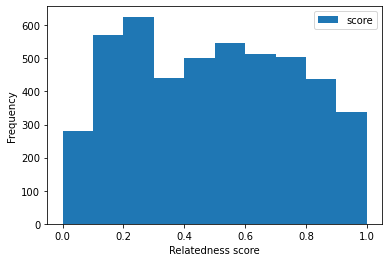

In [13]:
ax = dev_df.plot.hist().set_xlabel("Relatedness score")

### Repeated pairs

The development data has some word pairs with multiple distinct scores in it. Here we create a `pd.Series` that contains these word pairs:

In [14]:
repeats = dev_df.groupby(['word1', 'word2']).apply(lambda x: x.score.var())

repeats = repeats[repeats > 0].sort_values(ascending=False)

repeats.name = 'score variance'

print("Looking into repeated pair entries:\n", repeats)

Looking into repeated pair entries:
 word1        word2     
buck         dollar        0.378592
furnace      stove         0.274653
cash         money         0.247104
boxing       round         0.189342
money        possession    0.187652
                             ...   
dollar       money         0.000069
combination  direction     0.000034
form         type          0.000014
delay        news          0.000014
noon         string        0.000001
Name: score variance, Length: 279, dtype: float64


In [15]:
repeats.shape[0]

279

The `pd.Series` is sorted with the highest variance items at the top:

In [16]:
repeats.head()

word1    word2     
buck     dollar        0.378592
furnace  stove         0.274653
cash     money         0.247104
boxing   round         0.189342
money    possession    0.187652
Name: score variance, dtype: float64

In [17]:
# TODO(schowdhary): Think about handling repeated similarity scores in the dev set.
# The repeats, along with their varied similarity scores, can be modelled into a probabilistic distance calculation approach.

## Evaluation

In [18]:
count_df = pd.read_csv(
    os.path.join(VSM_HOME, "giga_window5-scaled.csv.gz"), index_col=0)
print("This is an embedding matrix of dimensions Row: {}, Column: {}".format(count_df.shape[0], count_df.shape[1]))
print("This giga5 dataset looks like this: \n", count_df.head())

This is an embedding matrix of dimensions Row: 6000, Column: 6000
This giga5 dataset looks like this: 
              ):           );            ..            ...        :(        :)  \
):     4.300000     8.100000      7.700000     113.766667  2.666667  1.116667   
);     8.100000  1092.400000      0.650000      52.783333  0.666667  0.000000   
..     7.700000     0.650000  18900.766667   12657.800000  0.500000  0.500000   
...  113.766667    52.783333  12657.800000  131656.033333  0.866667  0.500000   
:(     2.666667     0.666667      0.500000       0.866667  0.000000  0.333333   

       :/   :D   :|   ;p  ...    younger         your   yourself      youth  \
):   0.50  0.0  0.0  0.0  ...   2.850000   147.633333   8.483333   4.500000   
);   0.00  0.0  0.0  0.0  ...   7.100000    44.400000   3.333333   7.116667   
..   0.00  0.5  0.0  0.0  ...   1.166667    29.883333   0.833333   0.250000   
...  0.85  0.0  0.0  0.0  ...  40.333333  2187.066667  89.750000  42.000000   
:(   0.00  0.0

In [19]:
count_pred_df, count_rho = vsm.word_relatedness_evaluation(dev_df, count_df)

In [20]:
count_rho

0.2776320615138188

In [21]:
print("Looking into the modified dataframe returned:\n", count_pred_df.head())

Looking into the modified dataframe returned:
      word1       word2  score  prediction
0  abandon      button   0.18   -0.336291
1  abandon  consigning   0.40   -0.085422
2  abandon       crane   0.16   -0.307229
3  abandon       ditch   0.63   -0.211550
4  abandon        left   0.57   -0.337866


It's instructive to compare this against a truly random system, which we can create by simply having a custom distance function that returns a random number in [0, 1] for each example, making no use of the VSM itself:

In [22]:
def random_scorer(x1, x2):
    """`x1` and `x2` are vectors, to conform to the requirements
    of `vsm.word_relatedness_evaluation`, but this function just
    returns a random number in [0, 1]."""
    return random.random()

In [23]:
random_pred_df, random_rho = vsm.word_relatedness_evaluation(
    dev_df, count_df, distfunc=random_scorer)

random_rho

-0.00059854523902375

This is a truly baseline system!

## Error analysis

For error analysis, we can look at the words with the largest delta between the gold score and the distance value in our VSM. We do these comparisons based on ranks, just as with our primary metric (Spearman $\rho$), and we normalize both rankings so that they have a comparable number of levels.

In [24]:
def error_analysis(pred_df):
    pred_df = pred_df.copy()
    pred_df['relatedness_rank'] = _normalized_ranking(pred_df.prediction)
    pred_df['score_rank'] = _normalized_ranking(pred_df.score)
    pred_df['error'] =  abs(pred_df['relatedness_rank'] - pred_df['score_rank'])
    return pred_df.sort_values('error')


def _normalized_ranking(series):
    ranks = series.rank(method='dense')
    return ranks / ranks.sum()

Best predictions:

In [25]:
error_analysis(count_pred_df).head()

,word1,word2,score,prediction,relatedness_rank,score_rank,error
3121,health,psychology,0.325000,-0.238147,0.000127,0.000127,3.284913e-08
2984,grey,purple,0.660000,-0.125642,0.000283,0.000283,3.895284e-08
2439,eye,organ,0.789141,-0.073605,0.000361,0.000361,6.168281e-08
3591,losses,play,0.543103,-0.163590,0.000223,0.000222,1.214181e-07
239,appearance,image,0.535000,-0.166412,0.000218,0.000218,1.518298e-07


Worst predictions:

In [26]:
error_analysis(count_pred_df).tail()

,word1,word2,score,prediction,relatedness_rank,score_rank,error
4643,submit,yield,0.916750,-0.473501,1.440789e-05,0.000423,0.000408
1010,bulletin,news,0.925926,-0.503304,1.082946e-05,0.000425,0.000414
4091,photo,picture,0.920000,-0.632888,2.165892e-06,0.000423,0.000421
3001,grow,sprouting,0.950000,-0.518391,9.134414e-06,0.000430,0.000421
4338,repeating,replicate,0.925000,-0.728052,3.766768e-07,0.000424,0.000424


### t-test reweighting

The t-test statistic can be thought of as a reweighting scheme. For a count matrix $X$, row index $i$, and column index $j$:

$$\textbf{ttest}(X, i, j) = 
\frac{
    P(X, i, j) - \big(P(X, i, *)P(X, *, j)\big)
}{
\sqrt{(P(X, i, *)P(X, *, j))}
}$$

where $P(X, i, j)$ is $X_{ij}$ divided by the total values in $X$, $P(X, i, *)$ is the sum of the values in row $i$ of $X$ divided by the total values in $X$, and $P(X, *, j)$ is the sum of the values in column $j$ of $X$ divided by the total values in $X$.


In [27]:
def ttest(df):
    col_totals = df.sum(axis=0)
    row_totals = df.sum(axis=1)
    full_total = col_totals.sum()
    
    prob_scaled_df = df/full_total
    
    prob_scaled_col_np = (col_totals/full_total).to_numpy()
    prob_scaled_row_np = (row_totals/full_total).to_numpy()
    prob_scaled_row_col_np = np.matmul(prob_scaled_row_np[..., np.newaxis], prob_scaled_col_np[np.newaxis, ...])
    
    norm_factor_prob_scaled_row_col_np = (1/np.sqrt(prob_scaled_row_col_np))
    
    ttest_df = (prob_scaled_df - prob_scaled_row_col_np) * (norm_factor_prob_scaled_row_col_np)
    
    return ttest_df


In [28]:
def test_ttest_implementation(func):
    """`func` should be `ttest`"""
    X = pd.DataFrame([
        [1.,  4.,  3.,  0.],
        [2., 43.,  7., 12.],
        [5.,  6., 19.,  0.],
        [1., 11.,  1.,  4.]])
    actual = np.array([
        [ 0.04655, -0.01337,  0.06346, -0.09507],
        [-0.11835,  0.13406, -0.20846,  0.10609],
        [ 0.16621, -0.23129,  0.38123, -0.18411],
        [-0.0231 ,  0.0563 , -0.14549,  0.10394]])
    predicted = func(X)
    assert np.array_equal(predicted.round(5), actual), \
        "Your ttest result is\n{}".format(predicted.round(5))

### Learned distance functions

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor

def run_knn_score_model(vsm_df, dev_df, test_size=0.20):
    X = knn_feature_matrix(vsm_df, dev_df)
    
    y = [-1 * row['score'] for index, row in dev_df.iterrows()]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    
    knn_model = KNeighborsRegressor()
    
    knn_model.fit(X_train, y_train)
    
    ret = knn_model.score(X_test, y_test)
    return ret
    
def knn_feature_matrix(vsm_df, rel_df):
    X = [knn_represent(row['word1'], row['word2'], vsm_df) for index, row in rel_df.iterrows()]
    return X


def knn_represent(word1, word2, vsm_df):
    if word1 not in vsm_df.index:
        raise ValueError('{} is not in this VSM'.format(word1))
    if word2 not in vsm_df.index:
        raise ValueError('{} is not in this VSM'.format(word2))
    
    w1 = vsm_df.loc[word1].to_numpy()
    w2 = vsm_df.loc[word2].to_numpy()
    w1_w2_concat_embedding = np.concatenate((w1, w2), axis=0)
    return w1_w2_concat_embedding



### My Investigations

In [30]:
# My peak score was: 0.748
if 'IS_GRADESCOPE_ENV' not in os.environ:
    # Code for the original system is a series of hit-trials, experiments and a manual beam-search for better models.
    # The code is literally-programmed in the subsection "Original System Design Decisions" below in various subpoints,
    # highlighting results and inferences
    # Breif Description of the system:
    # 1. Since word-word relation is best described by contextual information, I selected only window the window-5 datasets for
    # my analysis
    # 2. As an addition, I also included open reuters document dataset, and preprocessed it along with other datasets to compare
    # and contranst its performance againt other datasets.
    # 3. All the additional datasets I used/preprocessed and cut down to fit a local CPU processing
    # are one time only. I have included my approach to do so in raw cells and then later I reuse
    # them from a dump I made.
    # 4. All calculations are local CPU calculations. I beleive a lot better score can be achieved
    # with BERT/RoBERTa models when they are trained on good contextual info.
    # 5. Compared various reweighting techniques (PPMI, PMI, ttest, etc)
    # 6. Compared amongst GloVe, AutoEncoder, AutoEncoder + LSA and selected better preforming pipelines. Also, 
    #    tuned them for optimal hyper-parameters manually.
    # 7. Created a separate VSM by training basic BERT on limited yelp academic dataset (truncated for
    #    acceptable CPU time)
    # 8. Created a hybrid VSM from BERT + various pipelines performing good above
    # 9. Compared various distance functions, (cosine, euclidian, learnt-dist) to choose the one
    #    that optimizes my hybrid VSM score
    pass

### Original System Design Decisions

#### 1. Dataset to use

Could find many sources of data, eg. Reuters documents (from NLTK). The ideal factors that contributed to my data selection is:

1. Less preprocessing time (because of limited time)
2. Larger vocabulary (but sadly the vocab was really large, so had to trim dowm to an intersection of full_task_vocab)
3. Not large enough vocab that my PC-CPU cannot handle
4. Compare how dataset from other sources/custom preprocessing can skew/benefit/corrupt my results
5. Since, finding relation between words looks like a more contextual job, I will be using giga_5 & yelp_5 datasets in ensemble.
6. To spice things up, I scraped and preprocessed a TF-IDF based reuters document corpus to make a wordXword matrix. This will be a part of the emsemble.
7. All the chosen count matrices are 2-D to limit the computations involved. And all of them are wordXword dataset matrices because it tends to adhere to the goal of word-word correspondance in both the dimensions.

##### 1.1. Create a basic count matrix from a large dataset (reuters 7k Docs X 26K words, trimmed down to ~4K X 4K words on a TF-IDF Document matrix)

The following **3 raw-cells** helped me for a one-time act of fetching reuters documents, **creating a wordXdocument matrix**, TF-IDFing it, matrix multiplying it to create a **document-contexed wordXword matrix**, limitting vocab to only the relevant full vocab mentioned above and dump my custom-preprocessed dataset.

**_Going forward, I evaluate this VSM against other VSMs I received_**

In [31]:
# import nltk
# # TODO(eveyone): Please enable the below download call for the first time downloads and 
# nltk.download('reuters')

# from nltk.corpus import reuters
# from sklearn.feature_extraction.text import CountVectorizer
# from sklearn.feature_extraction.text import TfidfTransformer

# # reuters_stopwords = nltk.corpus.stopwords.words()
# # print(reuters.words())
# # reuters_vocab_repeated = [w.lower() for w in reuters.words() if w.isalnum() and w.lower() not in reuters_stopwords]
# # reuters_vocab = set(reuters_vocab_repeated)
# # print(len(reuters_vocab))

# files = [f for f in reuters.fileids() if 'training' in f]
# reuters_doc_corpus = [reuters.raw(fileids=[f]) for f in files]
# # print(reuters_doc_corpus[0])
# len(reuters_doc_corpus)

# reuters_vectorizer = CountVectorizer(stop_words='english')
# reuters_count = reuters_vectorizer.fit_transform(reuters_doc_corpus)
# tfidf = TfidfTransformer()
# tfidf_reuters_count = tfidf.fit_transform(reuters_count)

# reuters_count_matrix = (tfidf_reuters_count.T * tfidf_reuters_count)
# # reuters_count_matrix.setdiag(0)
# print(reuters_count.shape)
# # print(reuters_count)
# print(reuters_count_matrix.shape)
# # print(reuters_count_matrix)

In [32]:
# # making reuters dataframe
# reuters_vocab = reuters_vectorizer.get_feature_names()
# reuters_df = pd.DataFrame(data=reuters_count_matrix.toarray(), columns=reuters_vocab, index = reuters_vocab)
# reuters_df.head()
# reuters_df.to_csv('reuters_word_word_count_tfidf_vsm.csv', sep=",")

In [33]:
# # Optimizing reuters matrix to account for only a subset (75%) of words found in full vocab
# c = set(reuters_df.columns) & set(full_task_vocab)
# print(len(c))
# not_c = reuters_df.columns.difference(list(c))
# not_c = list(not_c)
# not_c_index = [reuters_df.columns.get_loc(name) for name in not_c]
# print(reuters_df.shape)

# reduced_reuters_df = reuters_df.drop(index=reuters_df.index[not_c_index])
# reduced_reuters_df = reduced_reuters_df.drop(not_c, axis=1)

# d = set(reduced_reuters_df.columns).issubset(set(full_task_vocab))
# print(d)
# print(reduced_reuters_df.shape)
# print(reduced_reuters_df.head())
# print(reduced_reuters_df.loc["bank"]["money"])
# reduced_reuters_df.to_csv('reduced_reuters_word_word_count_tfidf_vsm.csv', sep=",")

In [34]:
# understanding how much is the created reuters subsampled & tf-idf'd dataset useful
if 'IS_GRADESCOPE_ENV' not in os.environ:
    reuters_df = create_df_for_known_datasets("reuters")
    reuters_vocab = list(reuters_df.columns)

    print("A test similarity to be seen between words drop and water:\n", reuters_df.loc["drop", "water"])
    index=0
    print("Top neighbors for the word 'water':")
    for data in reuters_df.loc["water"]:
        if data > 0.1:
            print(reuters_vocab[index])
        index+=1
    concordance = dev_vocab & set(reuters_vocab)
    len(concordance)

A test similarity to be seen between words drop and water:
 0.0020638083613651
Top neighbors for the word 'water':
areas
california
davis
drought
ferry
french
gulf
march
parts
production
restrictions
said
shipping
stock
waste
water
weather
works


In [35]:
# Creating custom dev_df that has rows that are only compliant with reuters data set
# Doing this, so that we can (at times) independenly evaluate reuters_df

if 'IS_GRADESCOPE_ENV' not in os.environ:
    print("Length of dev_df is:\n", len(dev_df.index))
    print("Looking into the dev_df once:\n", dev_df.head())
    reduced_dev_df_rows = []

    for ind in dev_df.index:
        if (dev_df["word1"][ind] in reuters_vocab) and (dev_df["word2"][ind] in reuters_vocab):
            reduced_dev_df_rows.append(ind)

    print("Reduced rows:\n", len(reduced_dev_df_rows))

    truncated_dev_df_rows = dev_df.index.difference(list(reduced_dev_df_rows))
    print("To be removed rows:\n", len(truncated_dev_df_rows))
    reduced_dev_df = dev_df.drop(index=truncated_dev_df_rows)
    print("Reduced dev_df for reuters dataset testing:\n", reduced_dev_df.head())

Length of dev_df is:
 4756
Looking into the dev_df once:
      word1       word2  score
0  abandon      button   0.18
1  abandon  consigning   0.40
2  abandon       crane   0.16
3  abandon       ditch   0.63
4  abandon        left   0.57
Reduced rows:
 2665
To be removed rows:
 2091
Reduced dev_df for reuters dataset testing:
         word1   word2  score
2     abandon   crane  0.160
3     abandon   ditch  0.630
4     abandon    left  0.570
9   absorbing   learn  0.757
14  abundance  wealth  0.680


#### 2. Uderstanding what kind of words (most frequent) are a part of devset

In [36]:
if 'IS_GRADESCOPE_ENV' not in os.environ:
    def get_word_frequencies(word_arr):
        freq_arr = defaultdict(int)
        for word in word_arr:
            freq_arr[word]+=1
        return freq_arr

    combined_dev_word_frequencies = defaultdict(int)
    dev_freq_arr1 = get_word_frequencies(dev_df.word1.values)
    dev_freq_arr2 = get_word_frequencies(dev_df.word2.values)

    for k in dev_vocab:
        combined_dev_word_frequencies[k] += dev_freq_arr1[k]
        combined_dev_word_frequencies[k] += dev_freq_arr2[k]

    view_combined_dev_word_frequencies = [(v,k) for k,v in combined_dev_word_frequencies.items()]
    view_combined_dev_word_frequencies.sort(reverse=True)

    print("Looking into the most popular words used in dev_df:\n", view_combined_dev_word_frequencies[:10])


Looking into the most popular words used in dev_df:
 [(28, 'money'), (26, 'sitting'), (25, 'shore'), (25, 'morning'), (25, 'car'), (24, 'fruit'), (23, 'scenery'), (23, 'patio'), (23, 'happy'), (23, 'eat')]


#### 3. Formalizing the datasets to be used (ensembled later on)

1. **_giga5-scaled_** weighted frequency wordXword (needs frequency-bias adjustment)
2. **_yelp5-scaled_** weighted frequency wordXword (needs frequency-bias adjustment)
3. **_reuters_** wordXword custom matrix, created above using the following steps:
    3.1 Load all documents from reuters
    3.2 Create a CountVectorizer object for it, leading to a docXwords (7KX26K dim)
    3.3 TD-IDF normalize the same to REMOVE the frequency-bias from the matrix
    3.4 Dot-product the matrix to get a 2-D wordXword normalized-count matrix

**Note:** Only (1) and (2) will require frequency adjustment. (3) right from creation itself is TF-IDF normalized. We can still look into further re-weighting it

In [37]:
if 'IS_GRADESCOPE_ENV' not in os.environ:
    giga5_count_df = create_df_for_known_datasets("giga5")
    yelp5_count_df = create_df_for_known_datasets("yelp5")
    normalized_reuters_df = create_df_for_known_datasets("reuters")
    giga20_count_df = create_df_for_known_datasets("giga20")
    yelp20_count_df = create_df_for_known_datasets("yelp20")

In [38]:
if 'IS_GRADESCOPE_ENV' not in os.environ:
    print("Looking into giga5 head:\n", giga5_count_df.head())
    print("Looking into yelp5 head:\n", yelp5_count_df.head())
    print("Looking into reuters head:\n", normalized_reuters_df.head())

Looking into giga5 head:
              ):           );            ..            ...        :(        :)  \
):     4.300000     8.100000      7.700000     113.766667  2.666667  1.116667   
);     8.100000  1092.400000      0.650000      52.783333  0.666667  0.000000   
..     7.700000     0.650000  18900.766667   12657.800000  0.500000  0.500000   
...  113.766667    52.783333  12657.800000  131656.033333  0.866667  0.500000   
:(     2.666667     0.666667      0.500000       0.866667  0.000000  0.333333   

       :/   :D   :|   ;p  ...    younger         your   yourself      youth  \
):   0.50  0.0  0.0  0.0  ...   2.850000   147.633333   8.483333   4.500000   
);   0.00  0.0  0.0  0.0  ...   7.100000    44.400000   3.333333   7.116667   
..   0.00  0.5  0.0  0.0  ...   1.166667    29.883333   0.833333   0.250000   
...  0.85  0.0  0.0  0.0  ...  40.333333  2187.066667  89.750000  42.000000   
:(   0.00  0.0  0.0  0.0  ...   0.000000     0.333333   0.000000   0.666667   

     zebra  

#### 4. 5-Window datasets vs 20-Window datasets

In [39]:
# Deciding between 20-window and 5-window data sets by evaluating them on ppmi and cosine distance

if 'IS_GRADESCOPE_ENV' not in os.environ:
    ppmi_giga20_count_df = vsm.pmi(giga20_count_df, positive=True) # using explicit values for future compat
    result = vsm.word_relatedness_evaluation(dev_df, ppmi_giga20_count_df, distfunc=vsm.cosine)
    print("Relatedness score for giga20:\n", result[1])

    ppmi_giga5_count_df = vsm.pmi(giga5_count_df, positive=True) # using explicit values for future compat
    result = vsm.word_relatedness_evaluation(dev_df, ppmi_giga5_count_df, distfunc=vsm.cosine)
    print("Relatedness score for giga5:\n", result[1])


    ppmi_yelp20_count_df = vsm.pmi(yelp20_count_df, positive=True) # using explicit values for future compat
    result = vsm.word_relatedness_evaluation(dev_df, ppmi_yelp20_count_df, distfunc=vsm.cosine)
    print("Relatedness score for yelp20:\n", result[1])

    ppmi_yelp5_count_df = vsm.pmi(yelp5_count_df, positive=True) # using explicit values for future compat
    result = vsm.word_relatedness_evaluation(dev_df, ppmi_yelp5_count_df, distfunc=vsm.cosine)
    print("Relatedness score for yelp5:\n", result[1])

Relatedness score for giga20:
 0.5861912198807531
Relatedness score for giga5:
 0.6387757761666896
Relatedness score for yelp20:
 0.5650551566737813
Relatedness score for yelp5:
 0.6033113402091933


**_Clearly, the giga/yelp 5-window datasets perform *strictly better* than 20-window counter parts._** Hence, proceeding with giga/yelp 5-window variants only from the given datasets

In [40]:
# verifying where the NEW custom reuters dataset performance stands with/without ppmi

if 'IS_GRADESCOPE_ENV' not in os.environ:
    ppmi_normalized_reuters_df = vsm.pmi(normalized_reuters_df, positive=True)

    result = vsm.word_relatedness_evaluation(reduced_dev_df, ppmi_normalized_reuters_df, distfunc=vsm.cosine)
    print("Relatedness score for ppmi reuters:\n", result[1])

    result = vsm.word_relatedness_evaluation(reduced_dev_df, normalized_reuters_df, distfunc=vsm.cosine)
    print("Relatedness score for reuters:\n", result[1])


Relatedness score for ppmi reuters:
 0.27234488614497265
Relatedness score for reuters:
 0.19884456693073269


**_We can see that with/without ppmi, reuters dataset (through TF-IDF) is not of much help._** Moreover, even after normalizing the counts in the reuters matrix, PPMI seems to help keep its score up.

Finally, we decide on an ensemble of (giga5, yelp5, reuters(just for experimentation)).

#### 5. PPMI vs PMI vs t-test

In [41]:
if 'IS_GRADESCOPE_ENV' not in os.environ:
    #giga5
    ppmi_giga5_count_df = vsm.pmi(giga5_count_df, positive=True)
    result = vsm.word_relatedness_evaluation(dev_df, ppmi_giga5_count_df, distfunc=vsm.cosine)
    print("Score for ppmi giga5:\n", result[1])

    pmi_giga5_count_df = vsm.pmi(giga5_count_df, positive=False)
    result = vsm.word_relatedness_evaluation(dev_df, pmi_giga5_count_df, distfunc=vsm.cosine)
    print("Score for pmi giga5:\n", result[1])

    ttest_giga5_count_df = ttest(giga5_count_df)
    result = vsm.word_relatedness_evaluation(dev_df, ttest_giga5_count_df, distfunc=vsm.cosine)
    print("Score for ttest giga5:\n", result[1])


    #yelp5
    ppmi_yelp5_count_df = vsm.pmi(yelp5_count_df, positive=True)
    result = vsm.word_relatedness_evaluation(dev_df, ppmi_yelp5_count_df, distfunc=vsm.cosine)
    print("Score for ppmi yelp5:\n", result[1])

    pmi_yelp5_count_df = vsm.pmi(yelp5_count_df, positive=False)
    result = vsm.word_relatedness_evaluation(dev_df, pmi_yelp5_count_df, distfunc=vsm.cosine)
    print("Score for pmi yelp5:\n", result[1])

    ttest_yelp5_count_df = ttest(yelp5_count_df)
    result = vsm.word_relatedness_evaluation(dev_df, ttest_yelp5_count_df, distfunc=vsm.cosine)
    print("Score for ttest yelp5:\n", result[1])


    #reuters
    ppmi_normalized_reuters_df = vsm.pmi(normalized_reuters_df, positive=True)
    result = vsm.word_relatedness_evaluation(reduced_dev_df, ppmi_normalized_reuters_df, distfunc=vsm.cosine)
    print("Score for ppmi reuters:\n", result[1])

    pmi_normalized_reuters_df = vsm.pmi(normalized_reuters_df, positive=False)
    result = vsm.word_relatedness_evaluation(reduced_dev_df, pmi_normalized_reuters_df, distfunc=vsm.cosine)
    print("Score for pmi reuters:\n", result[1])

    ttest_normalized_reuters_df = ttest(normalized_reuters_df)
    result = vsm.word_relatedness_evaluation(reduced_dev_df, ttest_normalized_reuters_df, distfunc=vsm.cosine)
    print("Score for ttest reuters:\n", result[1])

Score for ppmi giga5:
 0.6387757761666896
Score for pmi giga5:
 0.38809678593279123
Score for ttest giga5:
 0.5895190785444602
Score for ppmi yelp5:
 0.6033113402091933
Score for pmi yelp5:
 0.4018392958839427
Score for ttest yelp5:
 0.5576636430247524
Score for ppmi reuters:
 0.27234488614497265
Score for pmi reuters:
 0.31405312137869995
Score for ttest reuters:
 0.33094679387455284


**_Looks like vanilla-pmi does not stand well in this case_**. Lets move forwards with the following pipeline,

_(giga5, yelp5, reuters)->(ppmi, ttest)-> ...to-be-investigated_

#### 6. Evaluate the decided pipeline till now

In [42]:
if 'IS_GRADESCOPE_ENV' not in os.environ:
    print("PPMI giga5:\n", vsm.neighbors('good', ppmi_giga5_count_df).head())
    print("\n")
    print("ttest giga5:\n", vsm.neighbors('good', ttest_giga5_count_df).head())
    print("\n")

    print("PPMI yelp5:\n", vsm.neighbors('good', ppmi_yelp5_count_df).head())
    print("\n")
    print("ttest yelp5:\n", vsm.neighbors('good', ttest_yelp5_count_df).head())
    print("\n")

    print("PPMI reuters:\n", vsm.neighbors('good', ppmi_normalized_reuters_df).head())
    print("\n")
    print("ttest reuters:\n", vsm.neighbors('good', ttest_normalized_reuters_df).head())
    print("\n")

PPMI giga5:
 good        0.000000
bad         0.439959
better      0.494448
terrific    0.509023
decent      0.520705
dtype: float64


ttest giga5:
 good        0.000000
bad         0.419279
exciting    0.523874
decent      0.526605
funny       0.533163
dtype: float64


PPMI yelp5:
 good         0.000000
decent       0.448116
great        0.466581
tasty        0.532094
excellent    0.569720
dtype: float64


ttest yelp5:
 good             0.000000
decent           0.338665
tasty            0.341665
great            0.432925
disappointing    0.492244
dtype: float64


PPMI reuters:
 good      0.000000
crop      0.630430
noted     0.650518
caused    0.691108
way       0.695074
dtype: float64


ttest reuters:
 good         0.000000
generally    0.654395
crop         0.673150
areas        0.718262
soil         0.750152
dtype: float64




An overview suggests that reuters data set has a **_lot of noise_** (as it considers entire documents). But the limited windowed approach in giga and yelp is turning out to be a great strategy.

#### 7. Dimension reduction (GloVe & Autoencoders)

Using LSA, we might look into the sigma matrix for an effective value of K (# of important dimensions).

In [43]:
# exploring k-value from LSA

if 'IS_GRADESCOPE_ENV' not in os.environ:
    # giga5 (assuming the similar for yelp 5)
    rowmat, singvals, colmat = np.linalg.svd(ppmi_giga5_count_df, full_matrices=False)
    singvals = np.diag(singvals)


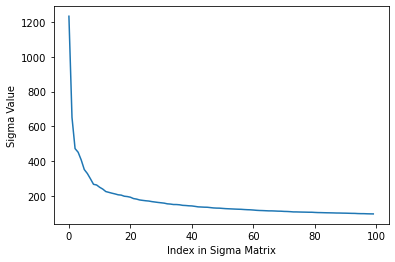

In [44]:
if 'IS_GRADESCOPE_ENV' not in os.environ:
    import matplotlib.pyplot as plt

    indexes = np.arange(100)
    sigma_vals = [singvals[i][i] for i in indexes]

    plt.plot(indexes, sigma_vals)
    plt.xlabel("Index in Sigma Matrix")
    plt.ylabel("Sigma Value")
    plt.show()
    # print(singvals)

In [45]:
if 'IS_GRADESCOPE_ENV' not in os.environ:
    rowmat, singvals, colmat = np.linalg.svd(ppmi_normalized_reuters_df, full_matrices=False)
    singvals = np.diag(singvals)

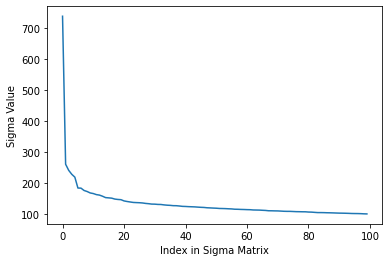

In [46]:
if 'IS_GRADESCOPE_ENV' not in os.environ:
    import matplotlib.pyplot as plt

    indexes = np.arange(100)
    sigma_vals = [singvals[i][i] for i in indexes]

    plt.plot(indexes, sigma_vals)
    plt.xlabel("Index in Sigma Matrix")
    plt.ylabel("Sigma Value")
    plt.show()
    # print(singvals)

Looking into the graphs, its almost indicative to use **_k=8_** (power of 2 and a small number) at the very least. For more accurate representations, we can increase k to higher values.

In [47]:
# exploring glove on giga5

if 'IS_GRADESCOPE_ENV' not in os.environ:
    from torch_glove import TorchGloVe

    glove_model = TorchGloVe(max_iter=256) # The performance improves till dim=256 and reduces for dim=512
    glv_ppmi_giga5_count_df = glove_model.fit(ppmi_giga5_count_df)

Finished epoch 256 of 256; error is 31385.8779296875

In [48]:
if 'IS_GRADESCOPE_ENV' not in os.environ:
    print("Neighbors for the word, 'good':\n", vsm.neighbors('good', glv_ppmi_giga5_count_df).head())
    print("GloVe output shape:\n", glv_ppmi_giga5_count_df.shape)
    print("Evaluation score for GloVe:\n", vsm.word_relatedness_evaluation(dev_df, glv_ppmi_giga5_count_df, distfunc=vsm.cosine)[1])

Neighbors for the word, 'good':
 good      0.000000
great     0.465420
best      0.496925
better    0.497365
bad       0.536105
dtype: float64
GloVe output shape:
 (6000, 100)
Evaluation score for GloVe:
 0.6177808429174492


In [49]:
# cascading the model is not possible as the model retrains from newly initialized weights
if 'IS_GRADESCOPE_ENV' not in os.environ:
    glove_model = TorchGloVe(max_iter=256)
    glv_ppmi_yelp5_count_df = glove_model.fit(ppmi_yelp5_count_df)

Finished epoch 256 of 256; error is 27460.36083984375

In [50]:
if 'IS_GRADESCOPE_ENV' not in os.environ:
    # print(glove_model.score(ppmi_yelp5_count_df))
#     print(vsm.neighbors('good', glv_ppmi_yelp5_count_df).head())
    print("GloVe output shape:\n", glv_ppmi_yelp5_count_df.shape)
    print("Evaluation score for GloVe:\n", vsm.word_relatedness_evaluation(dev_df, glv_ppmi_yelp5_count_df, distfunc=vsm.cosine)[1])

GloVe output shape:
 (6000, 100)
Evaluation score for GloVe:
 0.5239634807192389


In [51]:
if 'IS_GRADESCOPE_ENV' not in os.environ:
    glove_model = TorchGloVe(max_iter=256)
    glv_ppmi_normalized_reuters_df = glove_model.fit(ppmi_normalized_reuters_df)

Finished epoch 256 of 256; error is 5694.194885253906

In [52]:
if 'IS_GRADESCOPE_ENV' not in os.environ:
    # print(glove_model.score(ppmi_normalized_reuters_df))
    print("Print some neighbours:\n", vsm.neighbors('good', glv_ppmi_normalized_reuters_df).head(10))
    print("GloVe output shape:\n", glv_ppmi_normalized_reuters_df.shape)
    print("Evaluation score for GloVe:\n", vsm.word_relatedness_evaluation(reduced_dev_df, glv_ppmi_normalized_reuters_df, distfunc=vsm.cosine)[1])

Print some neighbours:
 good         0.000000
areas        0.478418
generally    0.568883
dry          0.593574
sense        0.605369
crop         0.610877
feel         0.621639
el           0.634712
excellent    0.656033
reduced      0.663880
dtype: float64
GloVe output shape:
 (4360, 100)
Evaluation score for GloVe:
 0.28416849826506063


In the reuters data set case, We can see only a few good words in the neighbourhood, that too quite far away. **_So this VSM does not look much promissing._**

In [53]:
# exploring autoencoders
# Since gloVe and AutoEncoders are non-linear dim-reducers, lets compare them

if 'IS_GRADESCOPE_ENV' not in os.environ:
    from torch_autoencoder import TorchAutoencoder

    torch_ae = TorchAutoencoder(hidden_dim=256, max_iter=256) # Error converges till dim=256 and then increases from 512
    ae_ppmi_giga5_count_df = torch_ae.fit(ppmi_giga5_count_df)


Stopping after epoch 210. Training loss did not improve more than tol=1e-05. Final error is 0.7978063374757767.

In [54]:
if 'IS_GRADESCOPE_ENV' not in os.environ:
    print("Score to help tweak hyperparameters:\n", vsm.word_relatedness_evaluation(dev_df, ae_ppmi_giga5_count_df, distfunc=vsm.cosine)[1])

Score to help tweak hyperparameters:
 0.6975455020932246


In [55]:
if 'IS_GRADESCOPE_ENV' not in os.environ:
    torch_ae = TorchAutoencoder(hidden_dim=256, max_iter=256)
    ae_ppmi_yelp5_count_df = torch_ae.fit(ppmi_yelp5_count_df)

Stopping after epoch 179. Training loss did not improve more than tol=1e-05. Final error is 1.147262305021286.

In [56]:
if 'IS_GRADESCOPE_ENV' not in os.environ:
    print("Score to help tweak hyperparameters:\n", vsm.word_relatedness_evaluation(dev_df, ae_ppmi_yelp5_count_df, distfunc=vsm.cosine)[1])

Score to help tweak hyperparameters:
 0.6694787563167136


In [57]:
if 'IS_GRADESCOPE_ENV' not in os.environ:
    torch_ae = TorchAutoencoder(hidden_dim=256, max_iter=256)
    ae_ppmi_normalized_reuters_df = torch_ae.fit(ppmi_normalized_reuters_df)

Stopping after epoch 132. Training loss did not improve more than tol=1e-05. Final error is 0.7034012228250504.

In [58]:
if 'IS_GRADESCOPE_ENV' not in os.environ:
    print("Score to help tweak hyperparameters:\n", vsm.word_relatedness_evaluation(reduced_dev_df, ae_ppmi_normalized_reuters_df, distfunc=vsm.cosine)[1])

Score to help tweak hyperparameters:
 0.3000571645281979


Both AE and glove did well on giga5 and yelp5. **_Keeping them in the pipeline_**

In [59]:
# A short experiment on AE_GloVe
if 'IS_GRADESCOPE_ENV' not in os.environ:
    glove_model = TorchGloVe(max_iter=512, embed_dim=512)
    glv_ppmi_giga5_count_df_transient = glove_model.fit(ppmi_giga5_count_df)
    torch_ae = TorchAutoencoder(hidden_dim=256, max_iter=256)
    ae_glv_ppmi_giga5_count_df = torch_ae.fit(glv_ppmi_giga5_count_df_transient)

Stopping after epoch 215. Training loss did not improve more than tol=1e-05. Final error is 0.20832013338804245.

In [60]:
# giga (AE + GloVe)
if 'IS_GRADESCOPE_ENV' not in os.environ:
    print("Worse score when AE and GloVe work in tandom:\n", vsm.word_relatedness_evaluation(dev_df, ae_glv_ppmi_giga5_count_df, distfunc=vsm.cosine)[1])

Worse score when AE and GloVe work in tandom:
 0.5748287486028694


The two methods GloVe and AE dont work great in tandom. In this case, they produced a result worse than both the individual layers. **_Since both are great individual non-linearities, one working on reconstruction error, other trying to relate the word with a joint probability of row+column, and since both cannot be used in tandom, we will create 2 separate pipelines for them._**

In [61]:
# AE vs AE-LSA
if 'IS_GRADESCOPE_ENV' not in os.environ:
    lsa_ppmi_giga5_count_df = vsm.lsa(ppmi_giga5_count_df, k=1024)
    torch_ae = TorchAutoencoder(hidden_dim=256, max_iter=256)
    ae_lsa_ppmi_giga5_count_df = torch_ae.fit(lsa_ppmi_giga5_count_df)


Finished epoch 256 of 256; error is 2.3869694769382477

In [62]:
if 'IS_GRADESCOPE_ENV' not in os.environ:
    print("AE+LSA score for hyperparameter tweak:\n", vsm.word_relatedness_evaluation(dev_df, ae_lsa_ppmi_giga5_count_df, distfunc=vsm.cosine)[1])
    print("AE score for reference:\n", vsm.word_relatedness_evaluation(dev_df, ae_ppmi_giga5_count_df, distfunc=vsm.cosine)[1])

AE+LSA score for hyperparameter tweak:
 0.6818947807207855
AE score for reference:
 0.6975455020932246


In [63]:
if 'IS_GRADESCOPE_ENV' not in os.environ:
    # yelp
    lsa_ppmi_yelp5_count_df = vsm.lsa(ppmi_yelp5_count_df, k=1024)
    torch_ae = TorchAutoencoder(hidden_dim=256, max_iter=256)
    ae_lsa_ppmi_yelp5_count_df = torch_ae.fit(lsa_ppmi_yelp5_count_df)

    # reuters
    lsa_ppmi_normalized_reuters_df = vsm.lsa(ppmi_normalized_reuters_df, k=1024)
    torch_ae = TorchAutoencoder(hidden_dim=256, max_iter=256)
    ae_lsa_ppmi_normalized_reuters_df = torch_ae.fit(lsa_ppmi_normalized_reuters_df)

Stopping after epoch 192. Training loss did not improve more than tol=1e-05. Final error is 1.9718127250671387.

In [64]:
if 'IS_GRADESCOPE_ENV' not in os.environ:
    # yelp
    print("AE+LSA score for hyperparameter tweak:\n", vsm.word_relatedness_evaluation(dev_df, ae_lsa_ppmi_yelp5_count_df, distfunc=vsm.cosine)[1])
    print("AE score for reference:\n", vsm.word_relatedness_evaluation(dev_df, ae_ppmi_yelp5_count_df, distfunc=vsm.cosine)[1])

    print("AE+LSA score for hyperparameter tweak:\n", vsm.word_relatedness_evaluation(reduced_dev_df, ae_lsa_ppmi_normalized_reuters_df, distfunc=vsm.cosine)[1])
    print("AE score for reference:\n", vsm.word_relatedness_evaluation(reduced_dev_df, ae_ppmi_normalized_reuters_df, distfunc=vsm.cosine)[1])

AE+LSA score for hyperparameter tweak:
 0.6510935967236118
AE score for reference:
 0.6694787563167136
AE+LSA score for hyperparameter tweak:
 0.27020694615238733
AE score for reference:
 0.3000571645281979


AE & AE+LSA  **_are quite close_**. Lets keep both into pipeline.

In [65]:
# Generating all the other variations (for ttest) from the above promising pipelines so far

if 'IS_GRADESCOPE_ENV' not in os.environ:
    # ae transformation...

    # giga5
    torch_ae = TorchAutoencoder(hidden_dim=256, max_iter=256)
    ae_ttest_giga5_count_df = torch_ae.fit(ttest_giga5_count_df)

    # yelp5
    torch_ae = TorchAutoencoder(hidden_dim=256, max_iter=256)
    ae_ttest_yelp5_count_df = torch_ae.fit(ttest_yelp5_count_df)

    # reuters
    torch_ae = TorchAutoencoder(hidden_dim=256, max_iter=256)
    ae_ttest_normalized_reuters_df = torch_ae.fit(ttest_normalized_reuters_df)

Stopping after epoch 21. Training loss did not improve more than tol=1e-05. Final error is 5.94779601215123e-06.

In [66]:
# evaluating ttest + ae
if 'IS_GRADESCOPE_ENV' not in os.environ:
    # giga
    print("AE+ttest score for hyperparameter tweak- giga:\n", vsm.word_relatedness_evaluation(dev_df, ae_ttest_giga5_count_df, distfunc=vsm.cosine)[1])

    # yelp
    print("AE+ttest score for hyperparameter tweak- yelp:\n", vsm.word_relatedness_evaluation(dev_df, ae_ttest_yelp5_count_df, distfunc=vsm.cosine)[1])

    # reuters
    print("AE+ttest score for hyperparameter tweak- reuters:\n", vsm.word_relatedness_evaluation(reduced_dev_df, ae_ttest_normalized_reuters_df, distfunc=vsm.cosine)[1])

AE+ttest score for hyperparameter tweak- giga:
 0.16743229953998381
AE+ttest score for hyperparameter tweak- yelp:
 0.14105993567991817
AE+ttest score for hyperparameter tweak- reuters:
 0.11105898754373882


**_Performance seems to have deteriorated on AE + ttest!!!_**

In [67]:
# ae + lsa + ttest transformation...

if 'IS_GRADESCOPE_ENV' not in os.environ:
    # giga5
    lsa_ttest_giga5_count_df = vsm.lsa(ttest_giga5_count_df, k=1024)
    torch_ae = TorchAutoencoder(hidden_dim=256, max_iter=256)
    ae_lsa_ttest_giga5_count_df = torch_ae.fit(lsa_ttest_giga5_count_df)

    # yelp5
    lsa_ttest_yelp5_count_df = vsm.lsa(ttest_yelp5_count_df, k=1024)
    torch_ae = TorchAutoencoder(hidden_dim=256, max_iter=256)
    ae_lsa_ttest_yelp5_count_df = torch_ae.fit(lsa_ttest_yelp5_count_df)

    # reuters
    lsa_ttest_normalized_reuters_df = vsm.lsa(ttest_normalized_reuters_df, k=1024)
    torch_ae = TorchAutoencoder(hidden_dim=256, max_iter=256)
    ae_lsa_ttest_normalized_reuters_df = torch_ae.fit(lsa_ttest_normalized_reuters_df)

Stopping after epoch 20. Training loss did not improve more than tol=1e-05. Final error is 2.1606054815492826e-05.

In [68]:
# evaluating ae + lsa + ttest
if 'IS_GRADESCOPE_ENV' not in os.environ:
    # giga
    print("AE+LSA+ttest score for hyperparameter tweak- giga:\n", vsm.word_relatedness_evaluation(dev_df, ae_lsa_ttest_giga5_count_df, distfunc=vsm.cosine)[1])
    print("LSA+ttest score for hyperparameter tweak- giga:\n", vsm.word_relatedness_evaluation(dev_df, lsa_ttest_giga5_count_df, distfunc=vsm.cosine)[1])
    # yelp
    print("AE+LSA+ttest score for hyperparameter tweak- yelp:\n", vsm.word_relatedness_evaluation(dev_df, ae_lsa_ttest_yelp5_count_df, distfunc=vsm.cosine)[1])
    print("LSA+ttest score for hyperparameter tweak- yelp:\n", vsm.word_relatedness_evaluation(dev_df, lsa_ttest_yelp5_count_df, distfunc=vsm.cosine)[1])
    # reuters
    print("AE+LSA+ttest score for hyperparameter tweak- reuters:\n", vsm.word_relatedness_evaluation(reduced_dev_df, ae_lsa_ttest_normalized_reuters_df, distfunc=vsm.cosine)[1])
    print("LSA+ttest score for hyperparameter tweak- reuters:\n", vsm.word_relatedness_evaluation(reduced_dev_df, lsa_ttest_normalized_reuters_df, distfunc=vsm.cosine)[1])

AE+LSA+ttest score for hyperparameter tweak- giga:
 0.17964273452565005
LSA+ttest score for hyperparameter tweak- giga:
 0.5742584194680079
AE+LSA+ttest score for hyperparameter tweak- yelp:
 0.14880680639339647
LSA+ttest score for hyperparameter tweak- yelp:
 0.5449956933799941
AE+LSA+ttest score for hyperparameter tweak- reuters:
 0.10941345565667673
LSA+ttest score for hyperparameter tweak- reuters:
 0.32538395177881674


In [69]:
if 'IS_GRADESCOPE_ENV' not in os.environ:
    print("Looking into why the scores are problematic:\n", ae_lsa_ttest_giga5_count_df.head())

Looking into why the scores are problematic:
           0         1         2         3         4         5         6    \
):  -0.014867 -0.030722  0.007129  0.007304  0.016619 -0.013515  0.002255   
);  -0.013661 -0.030278  0.008017  0.008904  0.017705 -0.013064  0.001867   
..  -0.010871 -0.027852  0.011323  0.013725  0.021494 -0.008538  0.002345   
... -0.011377 -0.031199  0.009025  0.009509  0.019510 -0.013639  0.003362   
:(  -0.013494 -0.030428  0.007887  0.008627  0.017266 -0.012821  0.001539   

          7         8         9    ...       246       247       248  \
):  -0.004243  0.018715 -0.000687  ... -0.016513  0.000713 -0.027058   
);  -0.001028  0.017108  0.000125  ... -0.017236  0.001502 -0.026019   
..  -0.004791  0.017916  0.000803  ... -0.010613  0.004737 -0.029778   
... -0.004596  0.015052  0.000410  ... -0.016695  0.000358 -0.029620   
:(  -0.001187  0.017037  0.000315  ... -0.016907  0.001235 -0.026627   

          249       250       251       252       253     

Looks like **_LSA+ttest might have some value_**

In [70]:
# Small experiment, Glove + ttest

if 'IS_GRADESCOPE_ENV' not in os.environ:
    # giga5
    glove_model = TorchGloVe(max_iter=256, alpha=0.75)
    glv_ttest_giga5_count_df = glove_model.fit(ttest_giga5_count_df)

Finished epoch 256 of 256; error is nan

The word representations converge to a same value or the errors reach a NAN, **_making ttest quite unstable for such dimension reduction techniques._**

Moreover, **_reuters(tf-idf'd) VSM performs consistently bad on word relatedness_**. **_This is expected as the VSM is constructed with a virtual context window of entire document, making it relate to words which might have simply appeared in the document without much relation to this word._** So, removing it from the pipeline too.

So, the models selected so far,

1. (giga5, yelp5)->(ttest) -> 2 models

2. (giga5, yelp5)->(ppmi)-> (ae, ae_lsa, glc) -> 6 models

#### 8. Using RoBERTa/BERT for augmenting static representation

**_Its difficult to use Bommasani's aggregated approach on a local PC (with CPU computations only) with a relevant set of corpus representing all/most of the full vocab words._** But, here I will try to get some review-texts from **yelp_academic_dataset** to make sure that I cover **most**/not all of the words from the full vocab list **atleast once**.

In the following raw code, I tried to fetch the yelp review dataset and read a small chunk of it till I cover approximately **90% of the full vocab list atleast once**. This gives a managable number of text sentences (approx 16k texts of size ~512 words). Since, this VSM cannot address all the full vocab questions, it is evaluated on a truncated dev set accordingly. At present, I will work with the "bert-base-case" model. Later, I might try a "roberta-large-model" on a small similar dataset.

**_Post a VSM generation, it is dumped on a csv, so that it can be reused again._**

In [71]:
# review_json_path = VSM_HOME + '/yelp_academic_dataset_review.json'

# size = 10000
# review = pd.read_json(review_json_path, lines=True,
#                       dtype={'review_id':str,'user_id':str,
#                              'business_id':str,'stars':int,
#                              'date':str,'text':str,'useful':int,
#                              'funny':int,'cool':int},
#                       chunksize=size)

# yelp_review_corpus = []

# for chunk_review in review:
#     yelp_review_corpus+= list(chunk_review["text"])
#     break

# print(len(yelp_review_corpus[0]))

In [72]:
# not_supported_vocab = []
# print(len(full_task_vocab)) # 6000
# for word in full_task_vocab:
#     found = False
#     for review in yelp_review_corpus:
#         if word in review:
#             found = True
#             break
    
#     if found is False:
#         not_supported_vocab.append(word)

# print(len(not_supported_vocab)) # 524
# # I leave out about 10% of vocab from the full_task_vocab to save time on bert/yelp dataset processing

Leaving only a few words from full vocab that dont have any samples from yelp open dataset

In [73]:
# # bert model
# import torch
# from transformers import BertModel, BertTokenizer
# from transformers import RobertaModel, RobertaTokenizer

# bert_weights_name = 'bert-base-uncased'
# bert_tokenizer = BertTokenizer.from_pretrained(bert_weights_name)
# bert_model = BertModel.from_pretrained(bert_weights_name)

# vocab_ids = {w: vsm.hf_encode(w, bert_tokenizer)[0] for w in full_task_vocab}
# print(vocab_ids)

In [74]:
# import textwrap

# # the bert model tokenizes sentences of max length 512. So truncated all sentenses
# # on a word limitting length to 500. 
# # The sentences might get INCOMPLETE. This might affect the performance but is simple!!!
# print(len(yelp_review_corpus))
# yelp_review_split_corpus = []

# for review in yelp_review_corpus: 
#     lines = textwrap.wrap(review, 500, break_long_words=False)
#     yelp_review_split_corpus+= lines

# print(len(yelp_review_split_corpus))

In [75]:
# corpus_ids = [vsm.hf_encode(text, bert_tokenizer)
#               for text in yelp_review_split_corpus]            

In [76]:
# # costly ~1.5 hrs
# corpus_reps = [vsm.hf_represent(ids, bert_model, layer=1)
#                for ids in corpus_ids]

In [77]:
# def find_sublist_indices(sublist, mainlist):
#     sublist = list(sublist)
#     mainlist = list(mainlist)
#     indices = []
#     length = len(sublist)
#     for i in range(0, len(mainlist)-length+1):
#         if mainlist[i: i+length] == sublist:
#             indices.append((i, i+length))
#     return indices

In [78]:
# %%time
# # EXTREMELY COSTLY, took 9h 10min 27s for a poor CPU
# vocab_bert_reps = {}

# for word in full_task_vocab:
#     vocab_word_id = vocab_ids[word]
#     vocab_word_reps = []
#     for ids, reps in zip(corpus_ids, corpus_reps):
#         offsets = find_sublist_indices(vocab_word_id, ids.squeeze(0))
#         for (start, end) in offsets:
#             pooled = vsm.mean_pooling(reps[:, start: end])
#             vocab_word_reps.append(pooled)
#     if len(vocab_word_reps) > 0:
#         vocab_word_rep = torch.mean(torch.cat(vocab_word_reps), axis=0).squeeze(0)
#     else:
#         vocab_word_rep = None
#     vocab_bert_reps[word] = vocab_word_rep

In [79]:
# # Converting representations to standard list to dump my custom bert-yelp reprs
# dict_vocab_bert_reps = {}
# bert_embedding_size = list(vocab_bert_reps["water"].shape)[0] # shape obtained for a regular embedding

# for (k, v) in vocab_bert_reps.items():
#     if v is not None:
#         dict_vocab_bert_reps[k] = list(v)
#         dict_vocab_bert_reps[k] = [elem.tolist() for elem in dict_vocab_bert_reps[k]]
#     else:
#         dict_vocab_bert_reps[k] = [0] * bert_embedding_size


In [80]:
# # One time bert-yelp 768 dim embedding dump for reusability
# bert_repr_df = pd.DataFrame.from_dict(dict_vocab_bert_reps, orient='index')
# # print(bert_repr_df.head())
# # print(bert_repr_df.loc["water"])
# bert_repr_df.to_csv('reduced_bert_word_repr_vsm.csv', sep=",") # on a test path
# # weights were later copied and compressed to VSM_HOME

In [81]:
if 'IS_GRADESCOPE_ENV' not in os.environ:
    bert_repr_df = create_df_for_known_datasets("bert-yelp")

    supported_bert_vocab = []
    bert_embedding_size = len(list(bert_repr_df.columns))
    print("Trained BERT's Embedding size:\n", bert_embedding_size)
    # print(bert_repr_df.head())
    # print(bert_repr_df.loc["water"])
    
    for index in bert_repr_df.index:
        # empty representations were filled with [0.....0]
        if list(bert_repr_df.loc[index]) == [0] * bert_embedding_size:
            continue
        supported_bert_vocab.append(index)

    # print(bert_repr_df["water"])
    print("Trained BERT's supported vocab size:\n", len(supported_bert_vocab))
    print("Trained BERT's sample supported vocab (subset of full vocab):\n", supported_bert_vocab[100:200])

Trained BERT's Embedding size:
 768
Trained BERT's supported vocab size:
 5557
Trained BERT's sample supported vocab (subset of full vocab):
 ['affordable', 'afraid', 'africa', 'african', 'after', 'afternoon', 'afterward', 'afterwards', 'again', 'against', 'age', 'aged', 'agency', 'agent', 'agents', 'ages', 'aggressive', 'ago', 'agree', 'agreed', 'agreement', 'ahead', 'aid', 'aim', 'air', 'aircraft', 'airline', 'airlines', 'airplane', 'airport', 'al', 'alan', 'alarm', 'alcohol', 'ale', 'alert', 'alex', 'alien', 'alive', 'all', 'allen', 'allergic', 'alleviated', 'alley', 'allow', 'allowed', 'allowing', 'allows', 'ally', 'almost', 'alone', 'along', 'alpha', 'alphabet', 'already', 'also', 'alter', 'alternative', 'although', 'aluminum', 'always', 'am', 'amateur', 'amateurish', 'amazing', 'america', "america's", 'american', 'americans', 'among', 'amount', 'amounted', 'amounts', 'ample', 'amusement', 'amy', 'an', 'analyzed', 'ancient', 'and', 'andrew', 'andy', 'angel', 'angeles', 'anger', 'a

In [82]:
# Creating custom dev_df that has rows that are only compliant with bert vocab
# Doing this, so that we can (at times) independenly evaluate bert embeddings
if 'IS_GRADESCOPE_ENV' not in os.environ:
    print("Length of dev_df testcases:\n", len(dev_df.index))
#     print(dev_df.head())
    reduced_bert_dev_df_rows = []

    for ind in dev_df.index:
        if (dev_df["word1"][ind] in supported_bert_vocab) and (dev_df["word2"][ind] in supported_bert_vocab):
            reduced_bert_dev_df_rows.append(ind)

    print("Number of testcases that this BERT can address out of this:\n", len(reduced_bert_dev_df_rows))

    truncated_bert_dev_df_rows = dev_df.index.difference(list(reduced_bert_dev_df_rows))
    print("No. of rows truncating to make a custom dev set for BERT's evaluation:\n", len(truncated_bert_dev_df_rows))
    reduced_bert_dev_df = dev_df.drop(index=truncated_bert_dev_df_rows)
    print("Head of reduced BERT solvable dev set:\n", reduced_bert_dev_df.head())


Length of dev_df testcases:
 4756
Number of testcases that this BERT can address out of this:
 4079
No. of rows truncating to make a custom dev set for BERT's evaluation:
 677
Head of reduced BERT solvable dev set:
      word1   word2  score
0  abandon  button   0.18
2  abandon   crane   0.16
3  abandon   ditch   0.63
4  abandon    left   0.57
5  abandon    ruin   0.64


In [83]:
# evaluating bert for word relatedness
if 'IS_GRADESCOPE_ENV' not in os.environ:
    print("Word relatedness score for BERT on reduced dev set:\n", vsm.word_relatedness_evaluation(reduced_bert_dev_df, bert_repr_df, distfunc=vsm.cosine)[1])

Word relatedness score for BERT on reduced dev set:
 0.7220921788801741


**_Depending on how much you can train bert weights using a lengthy corpus, you can get really great results!!! BEST for me so far_...**

#### 9. BERT with AutoEncoder to reduce its dimentions??? Lets see

In [84]:
if 'IS_GRADESCOPE_ENV' not in os.environ:
    torch_ae = TorchAutoencoder(hidden_dim=128, max_iter=128)
    ae_bert_repr_df = torch_ae.fit(bert_repr_df)

Finished epoch 128 of 128; error is 1.1973442286252975

In [85]:
if 'IS_GRADESCOPE_ENV' not in os.environ:
    print("Reference score for this pipeline's evaluation:\n", vsm.word_relatedness_evaluation(reduced_bert_dev_df, ae_bert_repr_df, distfunc=vsm.cosine)[1])

Reference score for this pipeline's evaluation:
 0.7251701809999062


**_Looks like there is not much benefit in reducing dimensions in a bert._**

#### 10. Evaluate how the "best" performing models above stand against each other

##### t-SNE Plot for an AE + PPMI model learnt

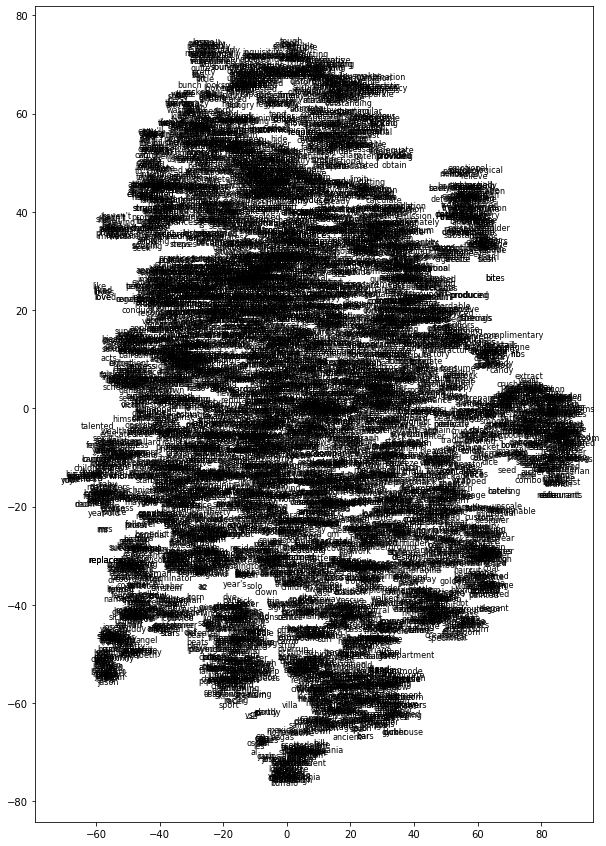

In [86]:
if 'IS_GRADESCOPE_ENV' not in os.environ:
    vsm.tsne_viz(ae_ppmi_giga5_count_df, figsize=(10, 15))

##### t-SNE Plot for an GloVe + PPMI model learnt

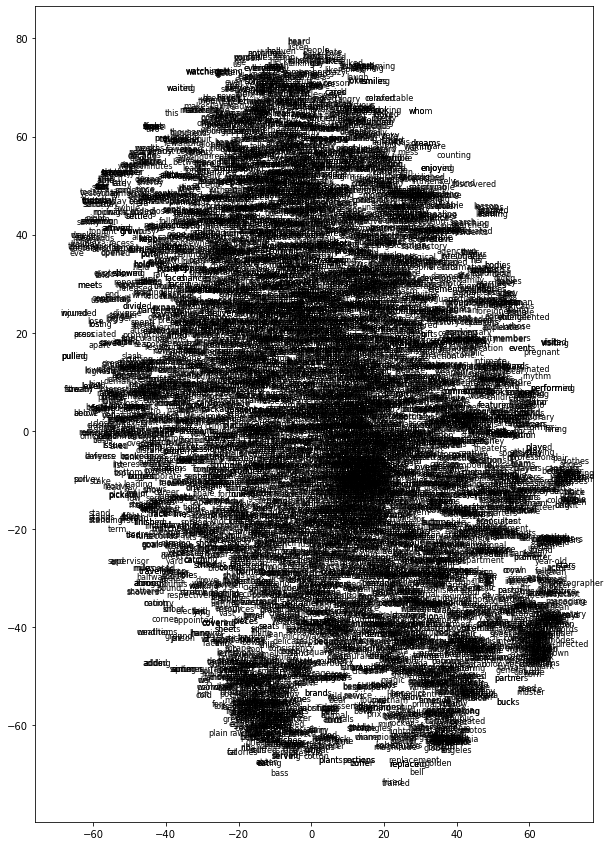

In [87]:
if 'IS_GRADESCOPE_ENV' not in os.environ:
    vsm.tsne_viz(glv_ppmi_giga5_count_df, figsize=(10, 15))

##### t-SNE Plot for an AE + LSA + PPMI model learnt

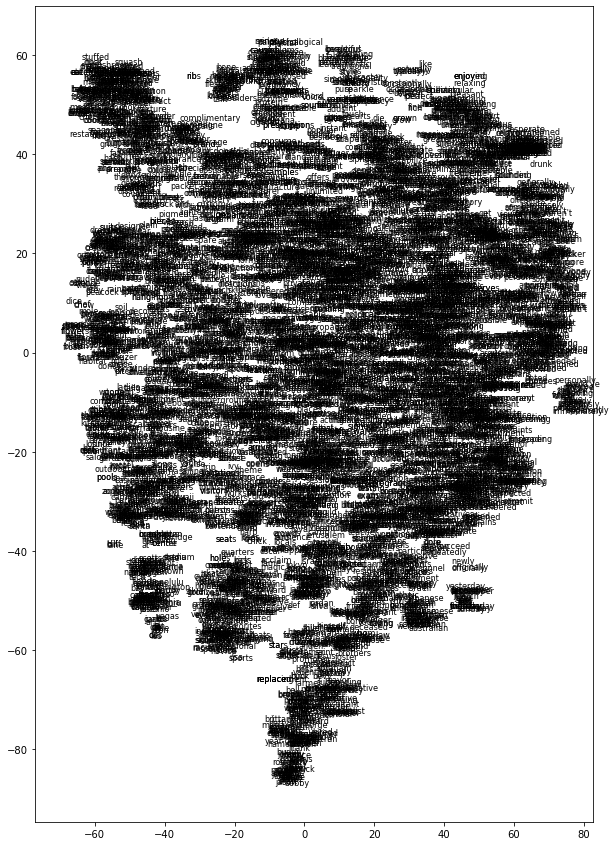

In [88]:
if 'IS_GRADESCOPE_ENV' not in os.environ:
    vsm.tsne_viz(ae_lsa_ppmi_giga5_count_df, figsize=(10, 15))

##### t-SNE Plot for an t-test model learnt

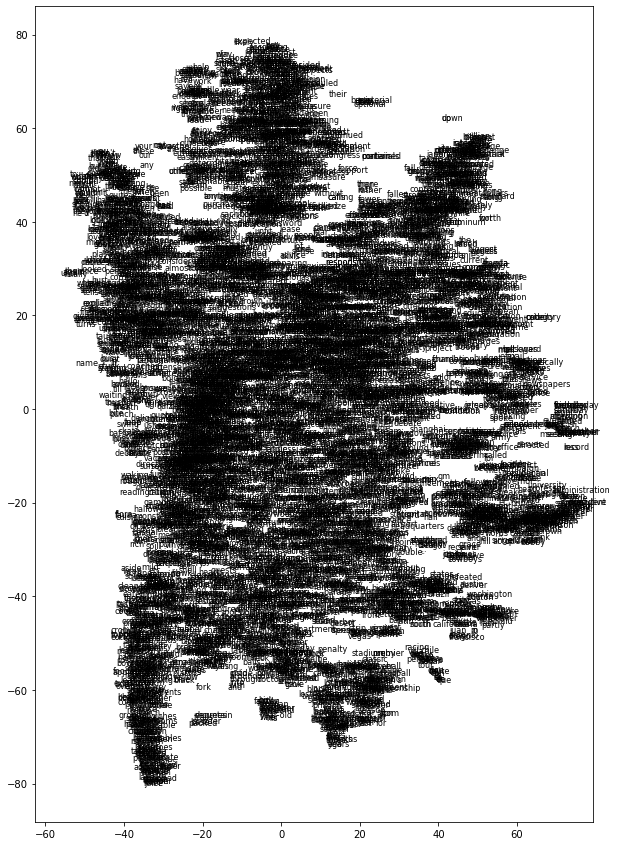

In [89]:
if 'IS_GRADESCOPE_ENV' not in os.environ:
    vsm.tsne_viz(ttest_giga5_count_df, figsize=(10, 15))

##### t-SNE Plot for a BERT model learnt

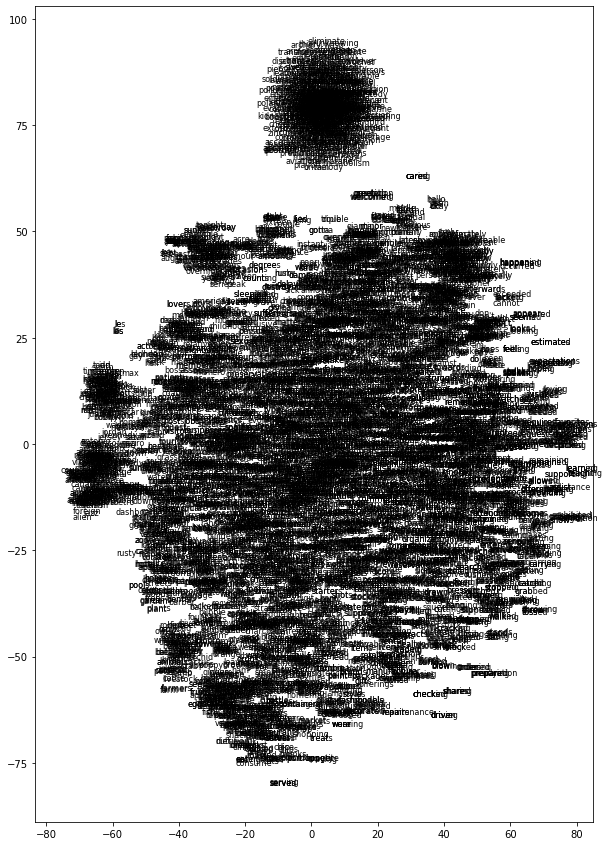

In [90]:
if 'IS_GRADESCOPE_ENV' not in os.environ:
    vsm.tsne_viz(bert_repr_df, figsize=(10, 15))

As we can see, all of these models **_did great on dev set and have a really different representation map!!!_**. Expecially BERT. Because of its high number of representation dimensions, it is **_way more unique_**.

Moreover, since this is **_just a word representation paradigm_**, we **_expect both formal and informal words_** in our test set. As a consequence, **_both giga5 and yelp5 inferences from a similar pipeline should be given SIMILAR weightage._**

Coming to weights, we now **_tweak the relative weights of these models_** to produce a **_hybrid VSM_**.

#### 11. Ensemble the 8 + 1 models so far 

After some manual hyper-parameter tuning, its found that **_a 0.4 weight on Bert model is optimal_**. The **_best performing model here is the one that uses Best + AE._** So technically the maximum score reported is **_0.748_**. But we know this is **_only a dev set score_**. 

In theory, **_AE Models_** should work similar to **_AE + LSA Models_**. Since, the AE Models have a tad better score here, we can select only one of those class of models. **_GloVe Models_**, even though have a little less score on dev-set, capture a different semantic relationship that is based on joint row-column probability. **_Hence, we would like to select that for test-set test-cases_**. **_t-test models do no perform that well and can be safely removed from this pipeline if the goal is to end up with a smaller-better-performing matrix._**

#### 12. Model Maker- generating the best model on the devset, but using a more sensible one for test set 

In [91]:
if 'IS_GRADESCOPE_ENV' not in os.environ:
    # returns a hybrid-model based on input specifications
    # Input: vsm_models -> list of vsm models that you want to ensemble
    #        vsm_model_weights -> list of numerical weights for the vsm_models in that order for ensemble
    #        task_vocab -> set/list of vocab words that the ensemble should work with. If the list
    #                      vsm_models does not work with task_vocab, None object is returned
    #
    # Output: hybrid_df -> a data-frame of hybrid VSM model. 
    # The routine does not check if atleast one model in vsm_models has the word representation for every word in
    # the task_vocab. So, hybrid_df can have all 0 representation for wrods if every model from
    # vsm_model returns a 0 representation for that word
    def ModelMaker(vsm_models, vsm_model_weights, task_vocab):
        assert len(vsm_models) == len(vsm_model_weights)
        hybrid_vsm_embedding_dim = 0
        hybrid_vsm_model_embedding_slices = []

        ind = 0
        for model in vsm_models:
            model_col_length = len(model.columns)
            hybrid_vsm_embedding_dim += model_col_length
            hybrid_vsm_model_embedding_slices.append((ind, ind + model_col_length))
            ind += model_col_length

        assert sum(vsm_model_weights) == 1, "vsm_model_weights's weights dont sum to 1"
        
        hybrid_df = None
        hybrid_df = pd.DataFrame(columns=np.arange(hybrid_vsm_embedding_dim), index=task_vocab)

        word_ind = 0
        for word in full_task_vocab:
            # it is guaranteed that the word will be found in all the VSMs
            # so if a word is not found in any of the vsm_models, we exit the function with None object return
            hybrid_entry_list = [0] * hybrid_vsm_embedding_dim
            model_ind = 0
            for model in vsm_models:
                if word not in model.index:
                    print("Model no: ", model_ind, " does not have the definition for the word: ", word, ". Nothing returned!")
                    return None
                
                model_to_word_embedding = model.loc[word]
                model_to_word_embedding = np.array(model_to_word_embedding)
                
                if not (model_to_word_embedding == np.zeros(len(model.columns))).all():
                    model_to_word_embedding = model_to_word_embedding/np.linalg.norm(model_to_word_embedding)

                hybrid_entry_list[hybrid_vsm_model_embedding_slices[model_ind][0] : hybrid_vsm_model_embedding_slices[model_ind][1]] \
                = list(vsm_model_weights[model_ind] * model_to_word_embedding)

                model_ind+=1

            hybrid_df.loc[word] = hybrid_entry_list
            word_ind +=1
            
        return hybrid_df

In [92]:
if 'IS_GRADESCOPE_ENV' not in os.environ:
    best_devset_model = ModelMaker(vsm_models=[bert_repr_df, ae_ppmi_giga5_count_df, ae_ppmi_yelp5_count_df], \
                                   vsm_model_weights=[0.4, 0.3, 0.3], task_vocab=full_task_vocab)

    print("Best model score on cosine so far using dev set:\n", vsm.word_relatedness_evaluation(dev_df,\
                                                                                                best_devset_model,\
                                                                                                distfunc=vsm.cosine)[1])

Best model score on cosine so far using dev set:
 0.7472947333884687


In [105]:
# dump best devset model to csv (1280 dims) for better reusability
# best_devset_model.to_csv('best_devset_word_repr_vsm.csv', sep=",") # on a test path
# weights were later copied and compressed to VSM_HOME

In [93]:
if 'IS_GRADESCOPE_ENV' not in os.environ:
    competing_model = ModelMaker(vsm_models=[bert_repr_df, ae_ppmi_giga5_count_df, ae_ppmi_yelp5_count_df, \
                                          glv_ppmi_giga5_count_df, glv_ppmi_yelp5_count_df], \
                              vsm_model_weights=[0.4, 0.2, 0.2, 0.1, 0.1], task_vocab=full_task_vocab)

    print("Competing model's score on cosine so far using dev set:\n", vsm.word_relatedness_evaluation(dev_df,\
                                                                                                competing_model,\
                                                                                                distfunc=vsm.cosine)[1])

Competing model's score on cosine so far using dev set:
 0.7429299668225708


In [107]:
# dump competing model to csv (1480 dims) for better reusability
# competing_model.to_csv('competing_word_repr_vsm.csv', sep=",") # on a test path
# weights were later copied and compressed to VSM_HOME

In [94]:
# Other variations tried

# [0.4, 0.15, 0.15, \
# 0.08, 0.08, \
# 0.06, 0.06, \
# 0.01, 0.01] -> 0.7329090099025598, (bert, aeX2, ae_lsaX2, glvX2, ttestX2)

# [0.4, 0.16, 0.16, \
# 0.08, 0.08, \
# 0.06, 0.06, \
# 0.00, 0.00] -> 0.7357002231197834, (bert, aeX2, ae_lsaX2, glvX2, -)

# [0.4, 0.15, 0.15, \
# 0.08, 0.08, \
# 0.06, 0.06, \
# 0.01, 0.01] -> 0.7329525147276932, (bert, aeX2, ae_lsaX2, glvX2, lsa_ttestX2)
    
# [0.4, 0.17, 0.17, \
# 0.08, 0.08, \
# 0.05, 0.05, \
# 0.00, 0.00] -> 0.7371324810708711, (bert, aeX2, ae_lsaX2, glvX2, -)

# [0.4, 0.3, 0.3, \
# 0.00, 0.00, \
# 0.00, 0.00, \
# 0.00, 0.00] ->0.7483399276185633, (bert, aeX2, -, -, -) <----- BEST DEVSET MODEL FOUND

# [0.4, 0.2, 0.2, \
# 0.00, 0.00, \
# 0.10, 0.10, \
# 0.00, 0.00] -> 0.743610336497744, (bert, aeX2, -, glvX2, -) <------ COMPETING MODEL AS THIS IS MORE PRACTICAL

In [95]:
if 'IS_GRADESCOPE_ENV' not in os.environ:
    # error evaluation
    best_model_pred_df = vsm.word_relatedness_evaluation(dev_df, best_devset_model, distfunc=vsm.cosine)[0]
    competing_model_pred_df = vsm.word_relatedness_evaluation(dev_df, competing_model, distfunc=vsm.cosine)[0]
    print("Error evaluation for Best Model:")
    print(error_analysis(best_model_pred_df).tail())
    print("Error evaluation for Competing Model:")
    print(error_analysis(competing_model_pred_df).tail())

Error evaluation for Best Model:
       word1          word2  score  prediction  relatedness_rank  score_rank  \
722    block         street  0.090   -0.620344          0.000342    0.000032   
1179    cash          money  0.210   -0.418608          0.000392    0.000079   
3885     new  unprecedented  0.857   -0.920284          0.000076    0.000396   
4443      se      sunflower  0.780   -0.960864          0.000025    0.000357   
1343  choose      nominated  0.867   -0.934562          0.000055    0.000399   

         error  
722   0.000309  
1179  0.000313  
3885  0.000320  
4443  0.000332  
1343  0.000343  
Error evaluation for Competing Model:
             word1          word2     score  prediction  relatedness_rank  \
4587     speculate       supposed  0.767000   -0.952587          0.000032   
3735          mind     psychology  0.763562   -0.955920          0.000029   
351   astronomical          large  0.880000   -0.919430          0.000078   
3885           new  unprecedented  0.8

Based on human perception, the best_devset_model seems to make a blunder on cash-money pair. But for the rest of the examples, it is fair that it gets confused. While on the other hand, the competing_model makes many blunders (engineering-plan, new-unprecedented, astronomical-large). **_Hence, in comparison, we would still prefer the best_devset_model over competing_model._**

#### 13. Optimizing on distance functions

Cosine function works fine as it compares normalized vectors. But lets try some experiments here!!!

In [96]:
if 'IS_GRADESCOPE_ENV' not in os.environ:
    # cosine
    print("Cosine based score evaluation:\n", vsm.word_relatedness_evaluation(dev_df, \
                                                                             best_devset_model, \
                                                                             distfunc=vsm.cosine)[1])

    print("Euclidian based score evaluation:\n", vsm.word_relatedness_evaluation(dev_df, \
                                                                                best_devset_model, \
                                                                                distfunc=vsm.euclidean)[1])

Cosine based score evaluation:
 0.7472947333884687
Euclidian based score evaluation:
 0.7054456532504473


In [97]:
if 'IS_GRADESCOPE_ENV' not in os.environ:
    print("Jaccard based score evaluation:\n", vsm.word_relatedness_evaluation(dev_df, \
                                                                              best_devset_model, \
                                                                              distfunc=vsm.jaccard)[1])

Jaccard based score evaluation:
 0.06239463012946248


Since, Jaccard is used for binary/binarixed data sets, real numbered vectors don't work well with it.

In [98]:
if 'IS_GRADESCOPE_ENV' not in os.environ:
    print("Comparing sample neighbours for the same model on Jaccard vs Cosine distance calc approach")
    print("Jaccard-based neigbours")
    vsm.neighbors("money", best_devset_model, distfunc=vsm.jaccard)
    print("Cosine-based neigbours")
    vsm.neighbors("money", best_devset_model, distfunc=vsm.cosine)

Comparing sample neighbours for the same model on Jaccard vs Cosine distance calc approach
Jaccard-based neigbours
Cosine-based neigbours


Its clear from the above sample. **_Jaccard is unable to produce neigbours for one of the most common word in dev-set._**

In [99]:
# normalized euclidian
if 'IS_GRADESCOPE_ENV' not in os.environ:
    def normalized_euclidian(u, v):
        return vsm.euclidean(vsm.length_norm(u), vsm.length_norm(v))
    
    print("Normalized-euclidian-based score: \n", vsm.word_relatedness_evaluation(dev_df, \
                                                                                 best_devset_model, \
                                                                                 distfunc=normalized_euclidian)[1])

    

Normalized-euclidian-based score: 
 0.7472947333884687


This score **_matches the best score from cosine._**

In [100]:
# Improper cosine
if 'IS_GRADESCOPE_ENV' not in os.environ:
    def improper_cosine_dist(u, v):
        return np.arccos(1 - vsm.cosine(u, v))/np.pi
    
    print("Improper cosine based score: \n", vsm.word_relatedness_evaluation(dev_df, \
                                                                            best_devset_model, \
                                                                            distfunc=improper_cosine_dist)[1])

Improper cosine based score: 
 0.7472947333884687


**_Similar score as the one with cosine metric_**

In [101]:
# learnt distance approach
if 'IS_GRADESCOPE_ENV' not in os.environ:
    def knn_distance_model(vsm_df, dev_df, test_size=0.2):
        X = knn_feature_matrix(vsm_df, dev_df)
        y = [row['score'] for index, row in dev_df.iterrows()]

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
        knn_model = KNeighborsRegressor()
        knn_model.fit(X_train, y_train)
        test_score = knn_model.score(X_test, y_test)

        return (knn_model, test_score)

In [102]:
if 'IS_GRADESCOPE_ENV' not in os.environ:    
    print("Results of knn regressor training...")
    ret = knn_distance_model(best_devset_model, dev_df, test_size=0.3)
    print("Regression score: \n", ret[1])
    
    def learnt_distance_func(u, v):
        concat_embedding = np.concatenate((u, v), axis=0)
        return -1 * ret[0].predict([concat_embedding])
    
    print("Relatedness score based on learnt distance:")
    print(vsm.word_relatedness_evaluation(dev_df, best_devset_model, distfunc=learnt_distance_func)[1])

Results of knn regressor training...
Regression score: 
 -0.027810363867386778
Relatedness score based on learnt distance:
0.5229804262052024


The learnt scores are not **_very great_**.

**_After all the distance function evaluations, only normalized-euclidian, euclidian, cosine and improper-cosine seem to work great._** There might be a little bias towards the selection of cosine/arccoss because we beam-searched for the model optimizations on this function itself. But since none of the performance-scores were even close to it, its safe to assume that normalized angle-based distance-metric works well enough for word relatedness.

Fianlly we close our research with:
1. **best_devset_model** achieveing the highest dev set score (to be submitted for bake-off)
2. **competing_model** that has the score quite close to (1) and also includes an ensemble of a variety of mutually independent models (BERT, AutoEncoders, PPMI, GloVe, all hyperparameter optimized)
3. **cosine** distance function to evaluate distance between word representations.

#### 14. Future work potential

The work does not cover a lot of other aspects that could have shed more light on this problem of word relatedness:
1. Retrofitting can be introduced to the vectors to evaluate for improvements
2. BERT models are extremely under-utilized for aggregated static representations. A GPU/TPU based accelerated training for the BERT model is also within the scope of evaluation.
3. Using RNN/LSTM could have led to better word relatedness capture across longer distances in a corpus without much noise addition.
4. Probabilistic models could have been used to model the aleotoric uncertainties in the dataset.
5. An automated beam-search for optimal pipelines/optimal hyper-parameters could have been used for faster/better convergence to an optimal model.
6. The ensemble-hybrid model weights are manually optimized. They could have been fed to a shallow neural network to get their optimized values.

#### 15. External Links/References
1. Apart from the datasets provided, this work augmented its inferences from the following:
    1. [Yelp_academic_dataset_review](https://www.yelp.com/dataset/download)
    2. [NLTK Reuters dataset](http://kdd.ics.uci.edu/databases/reuters21578/reuters21578.html)
2. Apart from this, some very large datasets/models are locally dumped for reusability.
3. [Prof. Chris Potts NLP Research Architechture](https://github.com/cgpotts/cs224u)